# General usage

In this notebook we illustrate general usage of the torchtuples `Model` with a binary classifier.

We will do the following:

- Use the [AdamWR optimizer](https://arxiv.org/pdf/1711.05101.pdf) with cyclical learning rates.
- Use the scheeme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate.
- Monitor accuracy in addition to loss during training.
- Use early stopping based on the validation loss to stop unnecessary computation and checkpoint the best model during training.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchtuples import Model, optim
import torchtuples.callbacks as cb
from torchtuples.practical import MLPVanilla, accuracy_binary

In [2]:
from sklearn.datasets import make_classification # to create a data set
from sklearn.model_selection import train_test_split

## Make the data set
We create a binary classification data set with `make_classification` and split it in training, validation and testing.

The data set is standardized, so we require no more preprocessing. However, we need to set the data type to 'float32', as torch does not work for 'float64', and we need y to be a column vector as this is expected by `torch.nn.BCEWithLogitsLoss`

In [3]:
# for reproducability
np.random.seed(1234)
_ = torch.manual_seed(4321)

In [4]:
n = 10000
x_train, y_train = make_classification(n)
x_train = x_train.astype('float32')
y_train = y_train.astype('float32').reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [5]:
train = (x_train, y_train)
val = (x_val, y_val)
test = (x_test, y_test)

## Make a torch MLP

Next, we need to make the torch net. For simplicity we will use `MLPVanilla` to make a two-hidden-layers MLP with 32 nodes in each layer, ReLU activation, batch norm and dropout of 0.1.

If you don't know how to make torch models, you shold see PyTorch has some [excellent tutorials](https://pytorch.org/tutorials/)

In [6]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1

net = MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

We now define the loss function (binary cross-entropy) and the optimizer (AdmamWR) and create a model. Note that we use decoupled weight decay for regularization and muliply the cycle length with 2 after every warm restart, and multiply the learning rate with 0.8 after every warm restart.

If we don't specify a `device`, the `Moded` will used gpu if avaiable.

In [7]:
optimizer = optim.AdamWR(decoupled_weight_decay=0.01, cycle_multiplier=2, cycle_eta_multiplier=0.8)
model = Model(net, torch.nn.BCEWithLogitsLoss(), optimizer)

## Finding a good learning rate

We can now use the scheeme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate.
`tolerance` is optinal and stops the procedyre when the loss becomes larger the the give value.

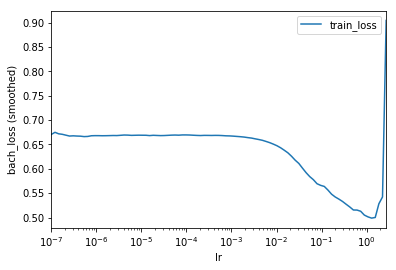

In [8]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

The plot displays the loss as function of learning rate (see fast.ai for explanations), and we have set a proposed learning rate for the model

In [9]:
model.optimizer.param_groups[0]['lr']

0.12915496650148922

This can also be found by

In [10]:
lrfinder.get_best_lr()

0.12915496650148922

Note that because we have reinitialized the optimizer after `lr_finder`, the optimizer of the model is no longer `optimizer`

In [11]:
model.optimizer is optimizer

False

We can also set a suitable learning rate for the network our selves:

In [12]:
model.optimizer.set_lr(0.1)
model.optimizer.param_groups[0]['lr']

0.1

The `get_best_lr` sometimes choose a too high learning rate, so we suggest that you set one yourself instead.

## Trainig

We can not fit the model. Fit we want to monitor the accuracy, wo we include `accuracy_binary` (from `torchtuples.practical`).
We can however replace this with a variaty of measures from `torch`, such as `torch.nn.functional.mse_loss` (thought MSE is not very useful here).

In [13]:
metrics = {'acc': accuracy_binary}

Next, we want to use early stopping to not wast time on unnecessary computations. As we have a cyclical optimizer, we will use the callback `EarlyStoppingCycle`, but for regular optimizers we suggest `EarlyStopping` instead. 

We have a patiace of one cycle, meaning that if we go a full cycle without obtaining a new 'best model', we will stop. `min_cycle` determines the minimum number of cycles we can iterate before allowed to stop.

The default behaviour is to monitor the validation loss, but we can change this metric to e.g. 'acc' got get the accuray instead.
Also, the default is to load the best performing model after we stop which is controlled by `load_best`.

In [14]:
es = cb.EarlyStoppingCycle(patience=1, min_cycles=6)

We can now fit the model and inspect the results. Note that we don't run for all 200 epochs

In [15]:
log = model.fit(x_train, y_train, batch_size, epochs=200, val_data=val, callbacks=[es], metrics=metrics)

0:	[0s / 0s],		train_loss: 0.3064,	train_acc: 0.8833,	val_loss: 0.2519,	val_acc: 0.9087
1:	[0s / 0s],		train_loss: 0.2406,	train_acc: 0.9116,	val_loss: 0.1735,	val_acc: 0.9425
2:	[0s / 0s],		train_loss: 0.2017,	train_acc: 0.9316,	val_loss: 0.1573,	val_acc: 0.9488
3:	[0s / 0s],		train_loss: 0.1991,	train_acc: 0.9284,	val_loss: 0.1535,	val_acc: 0.9413
4:	[0s / 0s],		train_loss: 0.1781,	train_acc: 0.9361,	val_loss: 0.1367,	val_acc: 0.9513
5:	[0s / 1s],		train_loss: 0.1628,	train_acc: 0.9419,	val_loss: 0.1354,	val_acc: 0.9506
6:	[0s / 1s],		train_loss: 0.1545,	train_acc: 0.9452,	val_loss: 0.1216,	val_acc: 0.9531
7:	[0s / 1s],		train_loss: 0.1701,	train_acc: 0.9341,	val_loss: 0.1371,	val_acc: 0.9513
8:	[0s / 1s],		train_loss: 0.1678,	train_acc: 0.9394,	val_loss: 0.1402,	val_acc: 0.9469
9:	[0s / 1s],		train_loss: 0.1562,	train_acc: 0.9414,	val_loss: 0.1234,	val_acc: 0.9575
10:	[0s / 1s],		train_loss: 0.1473,	train_acc: 0.9447,	val_loss: 0.1166,	val_acc: 0.9556
11:	[0s / 1s],		train_loss: 0.1

Next, we can plot the trainig progress with the first plot giving the loss, and the second giving the accuracy.A

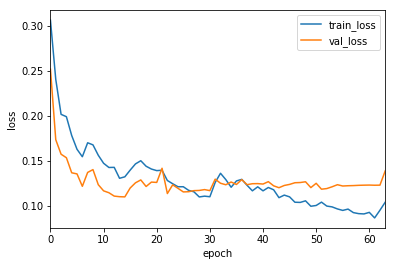

In [16]:
log.to_pandas()[['train_loss', 'val_loss']].plot()
plt.xlabel('epoch')
_ = plt.ylabel('loss')

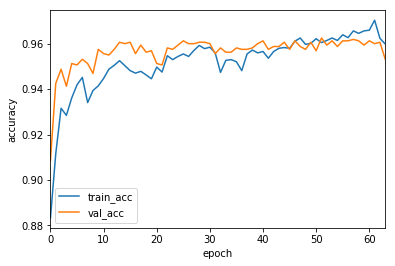

In [17]:
log.to_pandas()[['train_acc', 'val_acc']].plot()
plt.xlabel('epoch')
_ = plt.ylabel('accuracy')

we can use `score_in_batches` to score a data set

In [18]:
model.score_in_batches(val)

{'loss': 0.10986289381980896, 'acc': 0.9599999785423279}

and we see that we have the same value as the smalles validation loss

In [19]:
log.to_pandas().val_loss.min()

0.10986289381980896

## Predictions

We can compare this with the training and test set, and we see that there is a small tenency to overfitting of the training and validation data

In [20]:
model.score_in_batches(train)

{'loss': 0.1159840002655983, 'acc': 0.95703125}

In [21]:
model.score_in_batches(test)

{'loss': 0.15351265668869019, 'acc': 0.9430000185966492}

We can alos use the `predict` method to obtain predictions and accuracy 

In [22]:
preds = model.predict(x_test, numpy=False).sigmoid().numpy()
((preds > 0.5) == y_test).mean()

0.943

## More on learning rates

As we use the AdamWR optimizer, we can inspect the development of the learning rates. First we take a look at the $\eta$'s that are multiplied with our orinigal learning rate.

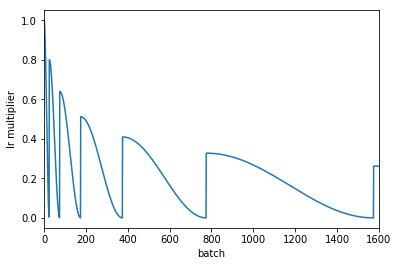

In [23]:
lr_multiplier = pd.Series(model.optimizer.lr_scheduler.get_etas())
lr_multiplier.plot()
plt.xlabel('batch')
_ = plt.ylabel("lr multiplier")

we can the obtarin the actual learning rates used by multiplying with the initial learning rate

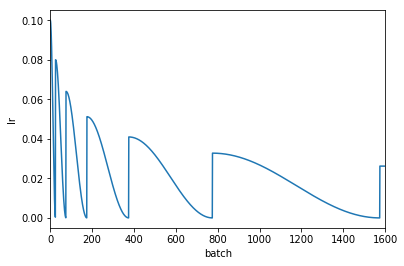

In [24]:
lrs = lr_multiplier * model.optimizer.param_groups[0]['initial_lr']
lrs.plot()
plt.xlabel('batch')
_ = plt.ylabel("lr")